In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")


In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

## Developing an agent for SCML2020

Let's see the simplest possible agent (a do-nothing agent)

In [3]:
from scml.scml2020 import SCML2020Agent, SCML2020World, RandomAgent, DecentralizingAgent
ComparisonAgent = DecentralizingAgent

In [4]:
class MyDoNothing(SCML2020Agent):
    """My Agent that does nothing"""

Now, let's try to run a simulation with it

In [5]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyDoNothing], n_steps=10), 
    construct_graphs=True,
)

### Do Nothing Agent

Let's test this agent to confirm that it is really doing nothing

In [6]:
world.run()

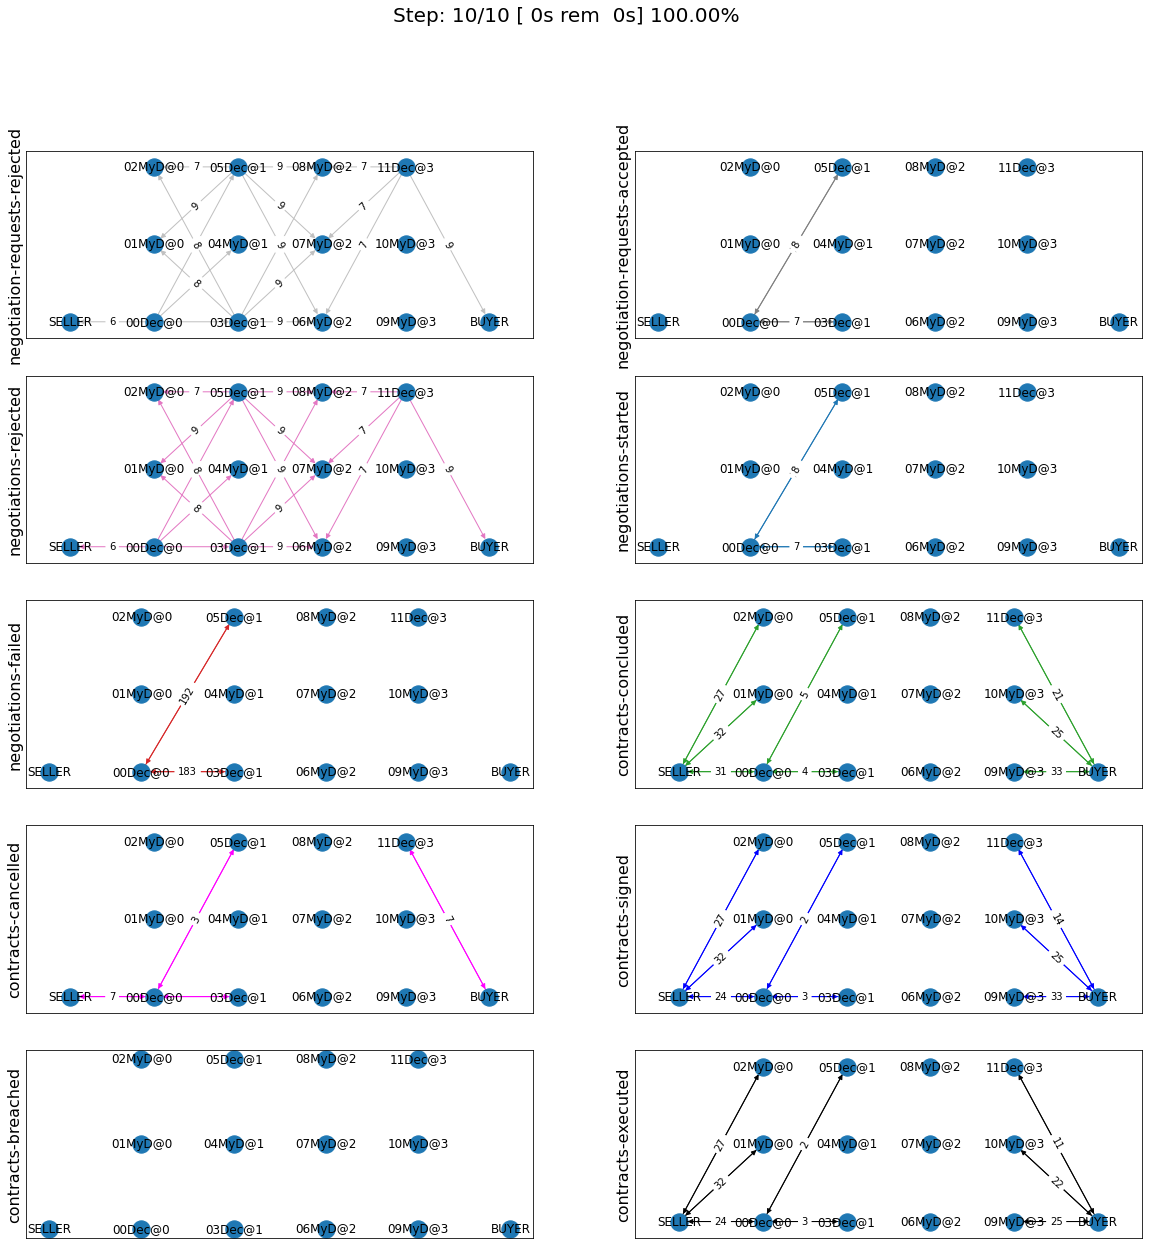

In [7]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

You can see that our agent did not do anything in the world. It did receive some negotiation requests which it rejected and it did not engage in any negotiations

### Agent Anatomy

For an agent to be successul in the SCML world, it needs to buy input materials through negotiation, manufacture them, then sell output products through negotiation. In this tutorial we structure our agent as a combination of three main strategies/components:

1. **Trading Strategy**: Deciding the quantity (and price) to buy and sell at every time-step. This component can employ two subcomponents: 
  - a pre-negotiation component that decides the quantities/prices to negotaite about based on prediction of future market behavior (**trade prediction strategy**) and partner behavior (**partner beahvior prediction strategy**)
  -  a post-negotiation component that decides what agreements to sign as contracts (**signing strategy**).
2. **Negotiation Control Strategy**: This component is responsible for proactively request negotiations, responding to negotiation requests and actually conducting concurrent negotaitions. This component can further be divided into two subcomponents:
  - a pre negotiation component that decides which negotiations to accept and which to engage in (**negotiation manager**)
  - The **negotiation algorithm** used to carry out the negotiations decided by the negotiation manger. 
3. **Production Strategy**: Decides what to produce at every time-step.

You are free to organize your agent in a different way but - for the purposes of this tutorial - we will stick with this organization. 

The SCML platform provides several components that can be used to implement each of these strategies.

#### Strategies
SCML uses collaborative inheritance for composing agents by combining components implement the strategies mentioned above.

Each one of those components can implement any of the methods/callbacks provided in the SCMLAgent class and use the AWI to do so as a representative of the agent. All of them call the `super` version of any method they override to make sure that all othe components get executed.

Components also reveal some useful members to other components and the main agent either as data-members, methods, or properties.  Let's see an example



In [8]:
from IPython.display import HTML
HTML('<img src="anatomy.png">')

In [9]:
import scml
print(scml.scml2020.components.TradingStrategy.__doc__)

Base class for all trading strategies.

    Provides:
        - `inputs_needed` (np.ndarray):  How many items of the input product do
          I need to buy at every time step (n_steps vector)
        - `outputs_needed` (np.ndarray):  How many items of the output product
          do I need to sell at every time step (n_steps vector)
        - `inputs_secured` (np.ndarray):  How many items of the input product I
          already contracted to buy (n_steps vector)
        - `outputs_secured` (np.ndarray):  How many units of the output product
          I already contracted to sell (n_steps vector)

    Hooks Into:
        - `init`
        - `internal_state`

    Remarks:
        - `Attributes` section describes the attributes that can be used to construct the component (passed to its
          `__init__` method).
        - `Provides` section describes the attributes (methods, properties, data-members) made available by this
          component directly. Note that everything provided b

The docstring above describes the six possible sections in each component's docstring which define how is it to be constructed (attributes), what it provides to other components (provides), what it assumes about the agent (requires), what abstract methods must be overriden by any subclass of it (abstract), which callbacks of the agent does it hook-into while allowing other components to run and which does it completely override (preventing components after it in the MRO from running).

**To successfully use components to construct your agent, you need to remember to always call the `super` version of every method you overrided in your agent class to allow all components to run except if you want to completey override the behavior of all components that use this callback.**. As a rule of thump, callbacks that start with "on_", "init", and "step" should call super, the rest should not.  For a clear explanation of the use of `super` refer to [Hettinger's post](https://rhettinger.wordpress.com/2011/05/26/super-considered-super/).

#### Production Strategy

Let's start with what may be the simplest of the aforementioned components: the production strategy. What should an agent produce? There are three main limitations on the answer to this question:

1. Production capacity which is controlled by the number of lines the agent has

    > self.awi.n_lines
    
2. The available quantity of the input material

    > self.awi.current_inventory(self.awi.my_input_product)

3. The *needed* quantity of outputs. That depends on how many sell contracts the agent already have (you may also consider future sell contracts that it expects to have).

The platform provides three basic strategies for production: SupplyDriven producing based on buy-contracts, DemandDriven producing based on sell-contracts and ContracDriven producing based on both.

Let's add a demand-driven strategy to our agent. This means that our agent will only produce based on the contracts it actually signs. 




In [10]:
from scml.scml2020.components.production import DemandDrivenProductionStrategy, ProductionStrategy
class MyAgent(DemandDrivenProductionStrategy):
    """My agent"""

As you can see, using this strategy and all other components provided by the SCML platform amounts to just inheriting from it. 
You have to remember when using any of these strategies to call `super().f` whenever you implement any of the methods in `SCML2020Agent` in your agent to allow the components you are using to do their thing.

It is instructive to see how does this strategy work. This is its complete code (with type-hints and the docstring removed):

In [11]:
class DemandDrivenProductionStrategy(ProductionStrategy):
    def on_contracts_finalized(self, signed, cancelled, rejectors):
        super().on_contracts_finalized(signed, cancelled, rejectors)
        for contract in signed:
            is_seller = contract.annotation["seller"] == self.id
            # do nothing if this is not a sell contract
            if not is_seller:
                continue
            step = contract.agreement["time"]
            # find the earliest time I can do anything about this contract
            earliest_production = self.awi.current_step
            if step > self.awi.n_steps - 1 or step < earliest_production:
                continue
            # Schedule production before the delivery time
            output_product = contract.annotation["product"]
            input_product = output_product - 1
            steps, _ = self.awi.schedule_production(
                process=input_product,
                repeats=contract.agreement["quantity"],
                step=(earliest_production, step - 1),
                line=-1,
                partial_ok=True,
            )
            # set the schedule_range which is provided for other components 
            self.schedule_range[contract.id] = (
                min(steps) if len(steps) > 0 else -1,
                max(steps) if len(steps) > 0 else -1,
                is_seller,
            )
            # that is all folks


This component works by implementing both `confirm_production` and `on_contracts_finalized`. 

- The main work happens in `on_contracts_finalized`. For each signed contract, the agent schedules as much production as possible to produce the required quantity before the time it is needed at.
- `confirm_production` simply confirms everything because it assumes that the agent already scheduled correctly. Notice that despite not needing to get the output of the call of `super`, it is already called to allow other components overriding this method to work properly.

Now let's test our agent with its new production strategy. 

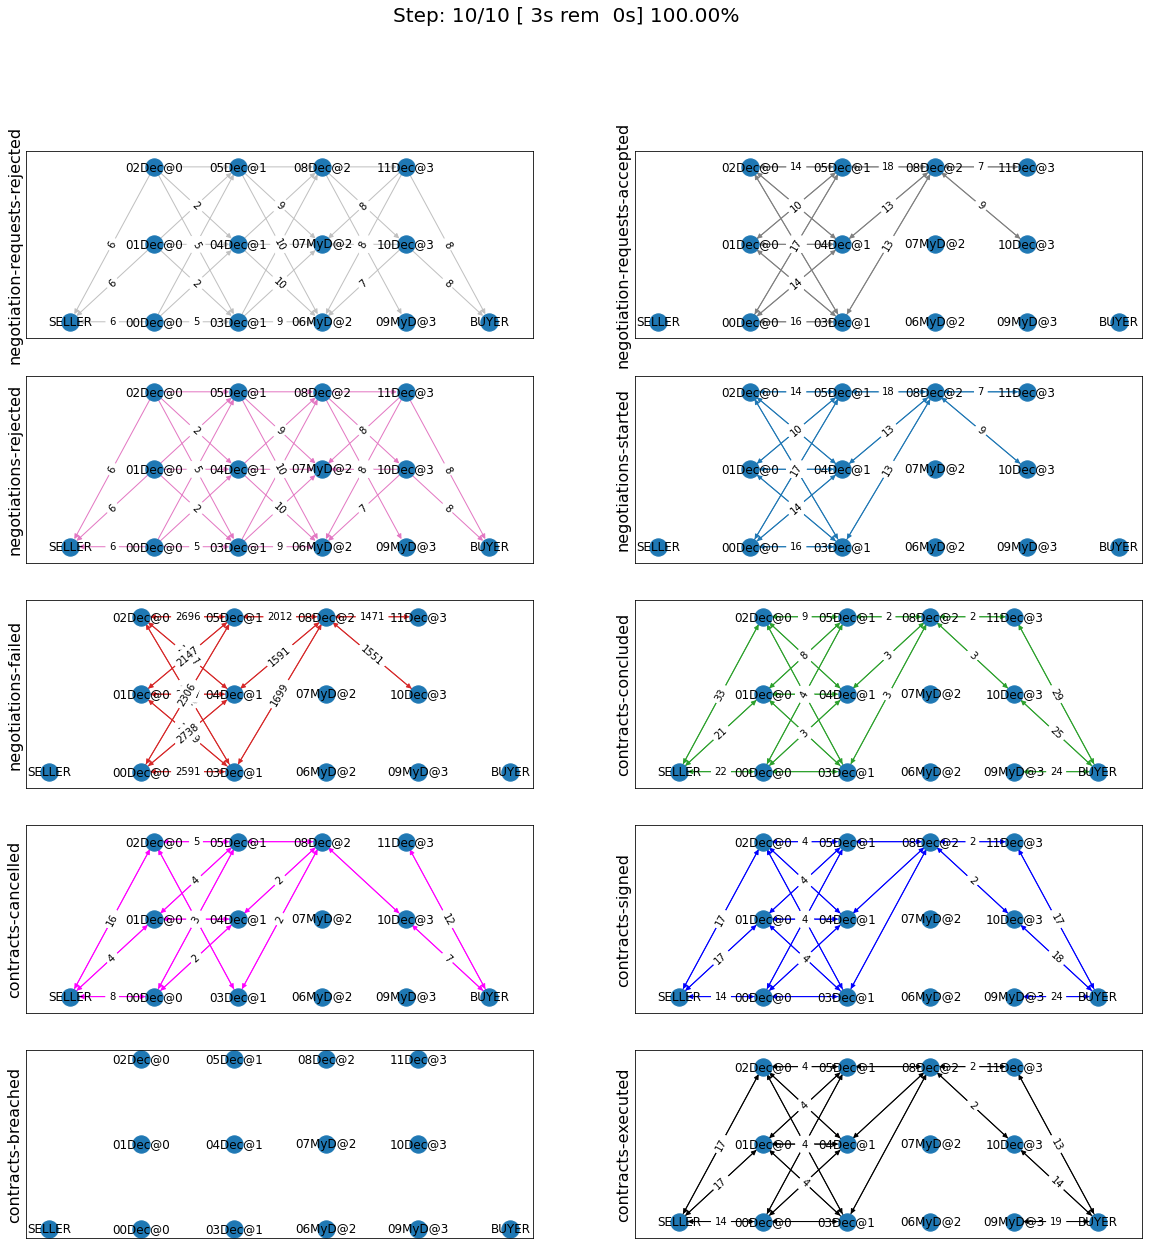

In [12]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyDoNothing], n_steps=10), 
    construct_graphs=True,
)
world.run()
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

As expected nothing happens. Our agent is still outside the market because it does not negotiate. We need to add the other two strategies (trading and negotiation control strategies) to get it going.

#### Trading Strategy

The second component of our agent, we will implement is the trading strategy. 

Trading strategies provide the following four data-members to the agent which can be used by other components:

- inputs_needed (np.ndarray):  How many items of the input product do I need at every time step (n_steps vector)
- outputs_needed (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_secured (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_needed (np.ndarray):  How many units of the output product I have already secured per step (n_steps vector)

There are two built-in trading strategies provided: 

1. `NoTradingStrategy` Simply sign any contracts that can in principle be satisifed given the production capacity (i.e. n. lines) of the factory. Other than that there is no strategy. This strategy is not expected to work well but is useful as a baseline.
2. `PredictionBasedTradingStrategy` This strategy use a trade prediction strategy internally to predict how many inputs are expected to be available and how many outputs are expected to be sold by the agent at every time-step. Given these two quantities, it maintains the amounts of inputs/outputs that it needs. It then employs a controller to manage negotiations and update the amounts secured.

Let's use the `PredictionBasedTradingStrategy` for our agent.

In [13]:
from scml.scml2020.components.production import DemandDrivenProductionStrategy
from scml.scml2020.components.trading import PredictionBasedTradingStrategy
class MyAgent(PredictionBasedTradingStrategy, DemandDrivenProductionStrategy, SCML2020Agent):
    """My agent"""

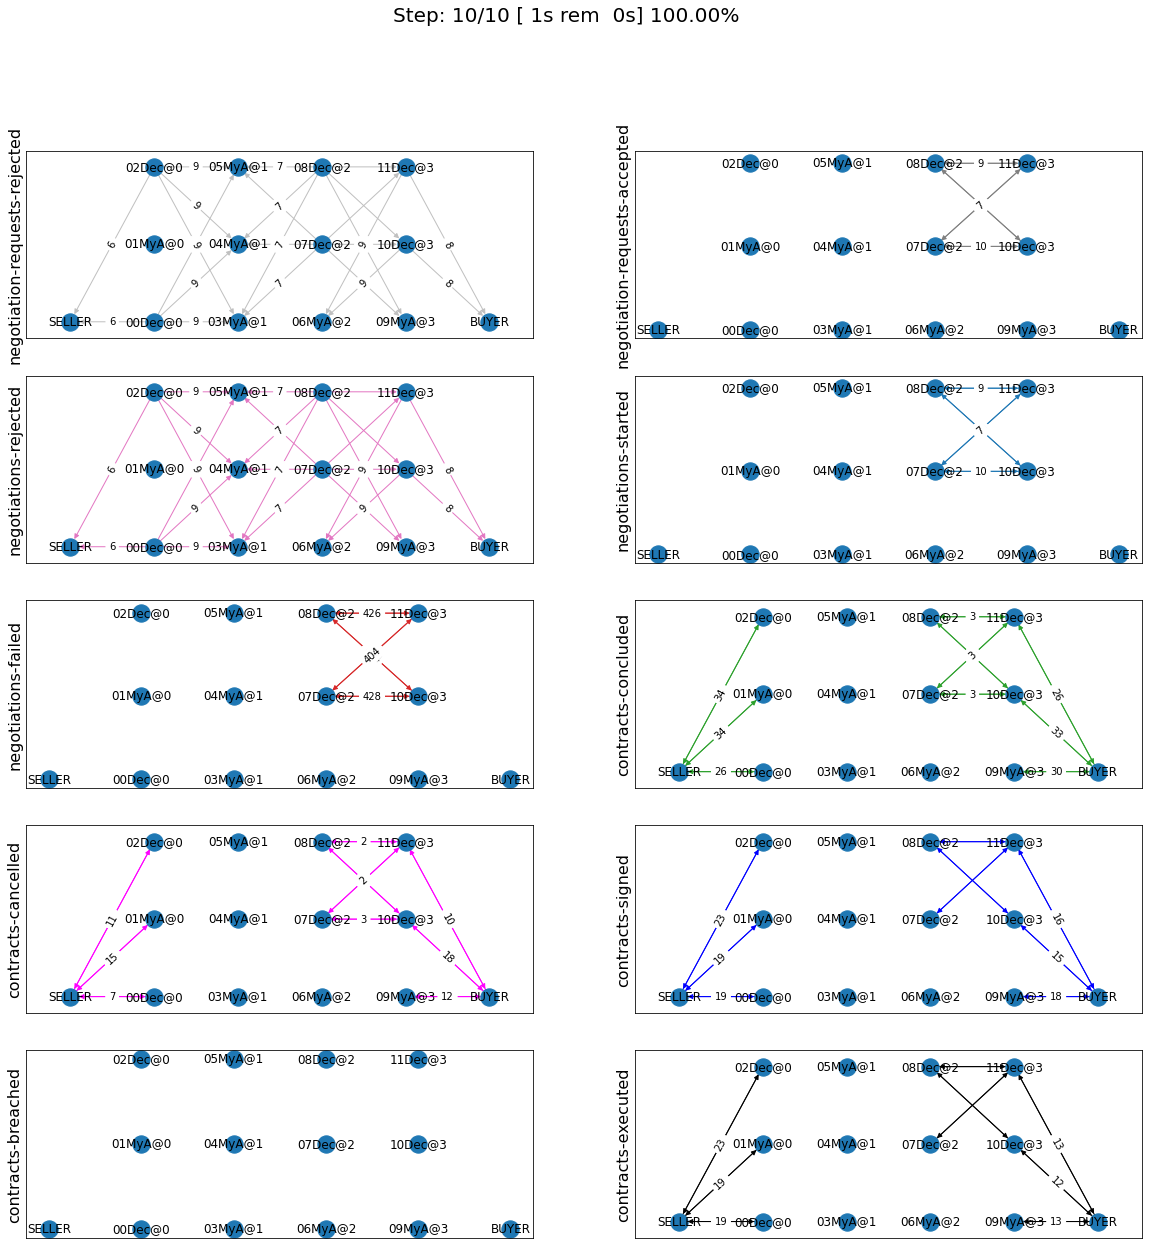

In [14]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyAgent], n_steps=10), 
    construct_graphs=True
)
world.run()
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

The last piece of the buzzle to complete our agent is to add a negotiation control strategy. We will start by reusing one of the existing strategies then develop our own.

#### Negotiation Control Strategy
Let's first try to just reuse one of the existing negotiation strategies to see how it works.


In [15]:
from scml.scml2020.components.negotiation import IndependentNegotiationsManager
class MyAgent(IndependentNegotiationsManager, PredictionBasedTradingStrategy, DemandDrivenProductionStrategy, SCML2020Agent):
    pass

In [16]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyAgent], n_steps=10), 
    construct_graphs=True
)
try:
    world.run()
except ValueError as e:
    print(e)

You must implement target_quantity


What the system is telling us is that we forgot to implement the method `targe_quantity` . Consulting the documentation we find that we must implement two methods to use any negotiation control strategy:

1. `target_quantity` which gives the quantity that the negotiators should targe to achieve for any given time step (selling and buying)
2. `acceptable_unit_price` The maximum acceptable unit price for buying and the minimum acceptable unit price for selling

Moreover, the independent negotiation strategy requires us to implement a utility function that should work for any negotiation. 

Let's add a simple implementation of both

In [17]:
from negmas import LinearUtilityFunction
class MyAgent(IndependentNegotiationsManager, PredictionBasedTradingStrategy
              , DemandDrivenProductionStrategy, SCML2020Agent):
    def target_quantity(self, step: int, sell: bool) -> int:
        """A fixed target quantity of half my production capacity"""
        return self.awi.n_lines // 2
        
    def acceptable_unit_price(self, step: int, sell: bool) -> int:
        """The catalog price seems OK"""
        return self.awi.catalog_prices[self.awi.my_output_product] if sell else self.awi.catalog_prices[self.awi.my_input_product]
    
    def create_ufun(self, is_seller: bool, issues=None, outcomes=None):
        """A utility function that penalizes high cost and late delivery for buying and and awards them for selling"""
        if is_seller:
            return LinearUtilityFunction((0, 0.25, 1))
        return LinearUtilityFunction((0, -0.5, -0.8))


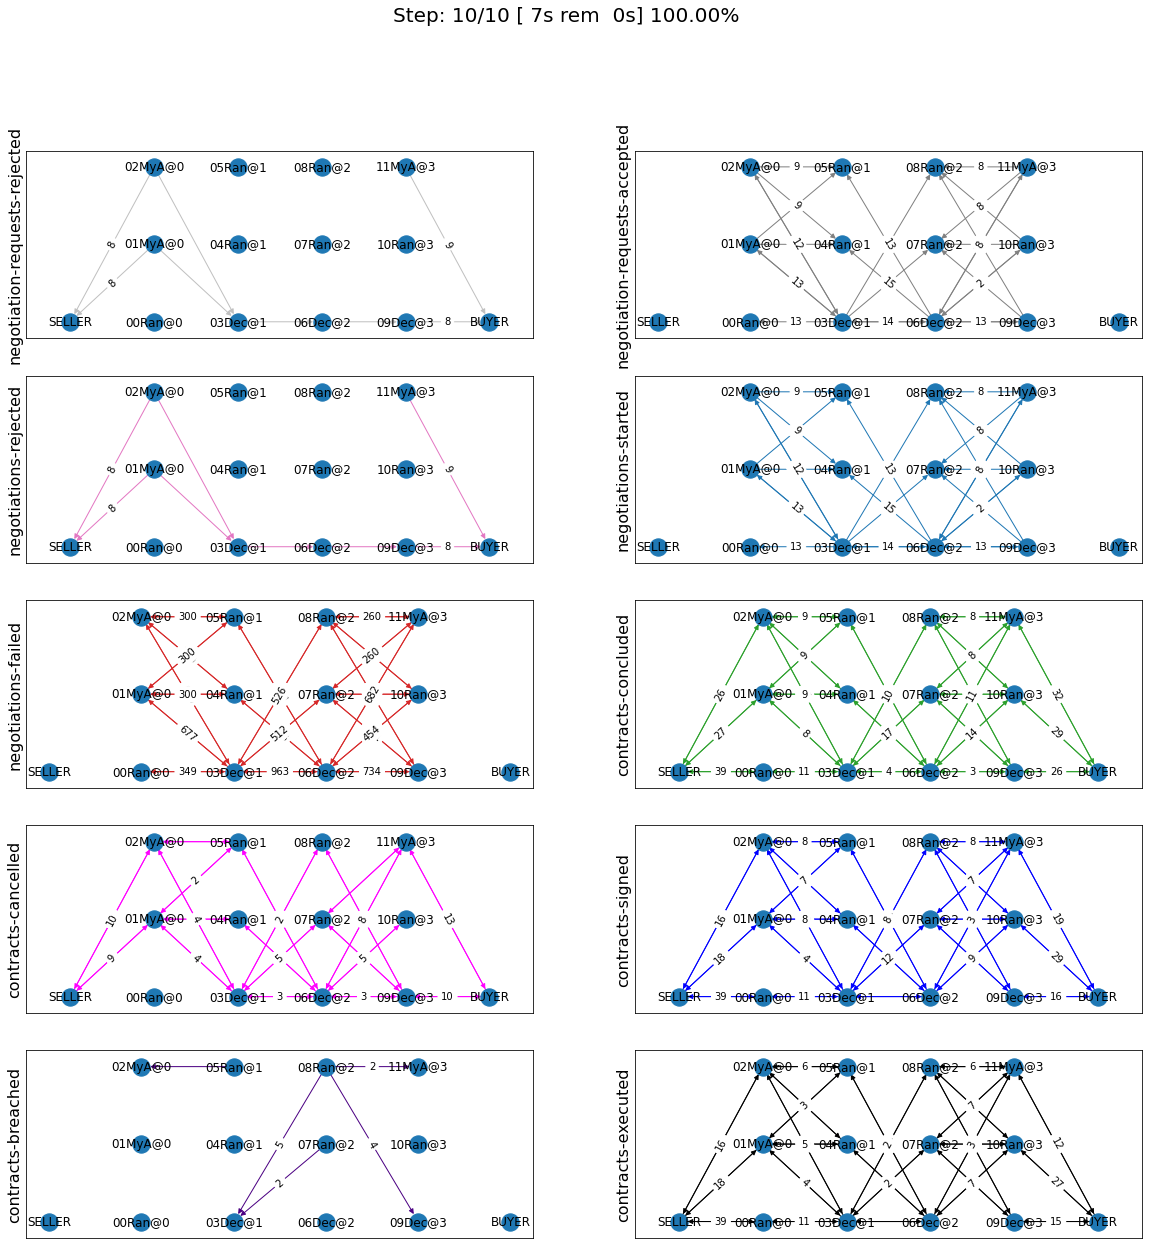

In [18]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyAgent, RandomAgent], n_steps=10), 
    construct_graphs=True
)
world.run()

world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()



Our agent is now doing things in the market. It buys and sells and commits breaches. How well is it doing?
Let's see how did our agents do

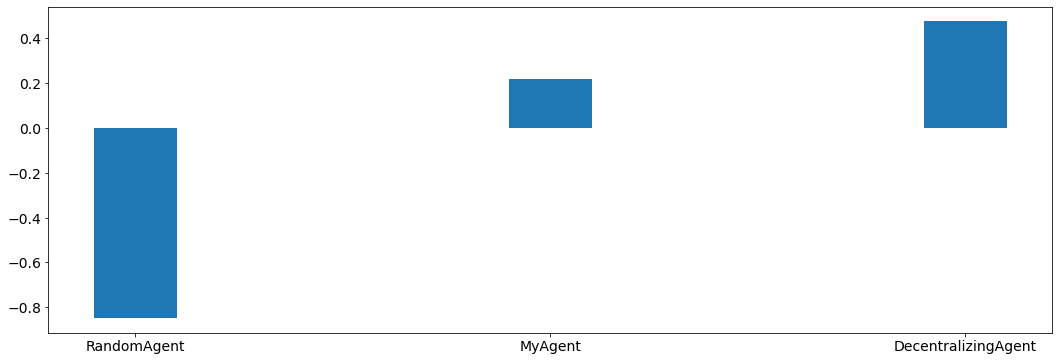

In [19]:
from collections import defaultdict
def show_agent_scores(world):
    scores = defaultdict(list)
    for aid, score in world.scores().items():
        scores[world.agents[aid].__class__.__name__.split(".")[-1]].append(score)
    scores = {k: sum(v)/len(v) for k, v in scores.items()}
    plt.bar(list(scores.keys()), list(scores.values()), width=0.2)
    plt.show()
show_agent_scores(world)

Not as good as the comparison agent :-( yet better than random :-)

But what did we expect with almost zero code. 

### Creating our own negotiation control strategy

Let's create a new negotiation control strategy and use it to replace the `IndependentNegotiationsManager` we used in our last attempt.

To start, we need to know what is expected from our component. 

We know that the trading strategy provides us with the following four data-members and we leave for it the responsibility of updating them correctly:

- inputs_needed (np.ndarray):  How many items of the input product do I need at every time step (n_steps vector)
- outputs_needed (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_secured (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_needed (np.ndarray):  How many units of the output product I have already secured per step (n_steps vector)

What we need from our negotiation control strategy is to find *the best* or at least *a good* way to satisfy these needs.

One way to do that is to have a `Controller` agent for selling and buying responsible of satisfying the *exact* needs at every time-step. 
NegMAS provides an easy to use controller that fits the bill called `SAOSyncController`


In [20]:
from negmas import SAOSyncController
print(SAOSyncController.__doc__)


    A controller that can manage multiple negotiators synchronously.

    Remarks:
        - The controller waits for an offer from each one of its negotiators before deciding what to do.
        - Loops may happen if multiple controllers of this type negotiate with each other. For example controller A
          is negotiating with B, C, while B is also negotiating with C. These loops are broken by the `SAOMechanism`
          by **forcing** some controllers to respond before they have all of the offers. In this case, `counter_all`
          will receive offers from one or more negotiators but not all of them.

    


Let's create our controller and see what do we need. The main idea here is that the controller will define a utility function for any possible outcome. It will then collect offers from all partners and responds in this way:

- If the best offer is invalid, reject everything and offer the best offer you can in every negotiation
- If the best offer is good enough (i.e. within some threshold of the best possible utility on that given negotiation) accept it
- Otherwise, send the best offer to everyone else and try to further improve this offer until near the end of the negotiation

This is a straight forward implementation of this idea

In [21]:
from scml.scml2020 import TIME, QUANTITY, UNIT_PRICE
from negmas import ResponseType, outcome_is_valid
from negmas.sao import SAOResponse
from typing import List, Dict, Optional, Tuple, Any
class SyncController(SAOSyncController):
    """
    Will try to get the best deal which is defined as being nearest to the agent 
    needs and with lowest price.
    
    Args:
        is_seller: Are we trying to sell (or to buy)?
        parent: The agent from which we will access `needed` and `secured` arrays
        price_weight: The importance of price in utility calculation
        utility_threshold: Accept anything with a relative utility above that
        time_threshold: Accept anything with a positive utility when we are that close
                        to the end of the negotiation
    """

    def __init__(
        self,
        *args,
        is_seller: bool,
        parent: "PredictionBasedTradingStrategy",
        price_weight=0.7,
        utility_threshold=0.9,
        time_threshold=0.9,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self._is_seller = is_seller
        self.__parent = parent
        self._time_threshold = time_threshold
        self._price_weight = price_weight
        self._utility_threshold = utility_threshold
        self._best_utils: Dict[str, float] = {}
        # find out my needs and the amount secured lists

    def utility(self, offer) -> float:
        """A simple utility function

        Remarks:
             - If the time is invalid or there is no need to get any more agreements
               at the given time, return -1000
             - Otherwise use the price-weight to calculate a linear combination of
               the price and the how much of the needs is satisfied by this contract

        """
        
        # get my needs and secured amounts arrays
        if self._is_seller:
            _needed, _secured = (
                self.__parent.outputs_needed,
                self.__parent.outputs_secured,
            )
        else:
            _needed, _secured = (
                self.__parent.inputs_needed,
                self.__parent.inputs_secured,
            )
        
        # invalide offers have no utility
        if offer is None:
            return -1000
        
        # offers for contracts that can never be executed have no utility
        t = offer[TIME]
        if t < self.__parent.awi.current_step or t > self.__parent.awi.n_steps - 1:
            return -1000.0
        
        # offers that exceed my needs have no utility (that can be improved)
        q = _needed[offer[TIME]] - (offer[QUANTITY] + _secured[t])
        if q < 0:
            return -1000.0
        
        # The utility of any offer is a linear combination of its price and how 
        # much it satisfy my needs
        price = (
            offer[UNIT_PRICE] 
            if self._is_seller 
            else -offer[UNIT_PRICE]
        )
        return self._price_weight * price + (1 - self._price_weight) * q

    def is_valid(self, negotiator_id: str, offer: "Outcome") -> bool:
        """Is this a valid offer for that negotiation"""
        issues = self.negotiators[negotiator_id][0].ami.issues
        return outcome_is_valid(offer, issues)

    def counter_all(
        self, offers: Dict[str, "Outcome"], states: Dict[str, "SAOState"]
    ) -> Dict[str, "SAOResponse"]:
        """Calculate a response to all offers from all negotiators (negotiator ID is the key).

        Args:
            offers: Maps negotiator IDs to offers
            states: Maps negotiator IDs to offers AT the time the offers were made.

        Remarks:
            - The response type CANNOT be WAIT.

        """

        # find the best offer
        negotiator_ids = list(offers.keys())
        utils = np.array([self.utility(o) for o in offers.values()])

        best_index = int(np.argmax(utils))
        best_utility = utils[best_index]
        best_partner = negotiator_ids[best_index]
        best_offer = offers[best_partner]

        # find my best proposal for each negotiation
        best_proposals = self.first_proposals()

        # if the best offer is still so bad just reject everything
        if best_utility < 0:
            return {
                k: SAOResponse(ResponseType.REJECT_OFFER, best_proposals[k])
                for k in offers.keys()
            }

        relative_time = min(_.relative_time for _ in states.values())

        # if this is good enough or the negotiation is about to end accept the best offer
        if (
            best_utility >= self._utility_threshold * self._best_utils[best_partner]
            or relative_time > self._time_threshold
        ):
            responses = {
                k: SAOResponse(
                    ResponseType.REJECT_OFFER,
                    best_offer if self.is_valid(k, best_offer) else best_proposals[k],
                )
                for k in offers.keys()
            }
            responses[best_partner] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
            return responses

        # send the best offer to everyone else and try to improve it
        responses = {
            k: SAOResponse(
                ResponseType.REJECT_OFFER,
                best_offer if self.is_valid(k, best_offer) else best_proposals[k],
            )
            for k in offers.keys()
        }
        responses[best_partner] = SAOResponse(
            ResponseType.REJECT_OFFER, best_proposals[best_partner]
        )
        return responses

    def first_proposals(self) -> Dict[str, "Outcome"]:
        """Gets a set of proposals to use for initializing the negotiation."""
        return {nid: self.best_proposal(nid)[0] for nid in self.negotiators.keys()}
    
    def on_negotiation_end(self, negotiator_id: str, state: "MechanismState") -> None:
        """Update the secured quantities whenever a negotiation ends"""
        if state.agreement is None:
            return

        q, t = state.agreement[QUANTITY], state.agreement[TIME]
        if self._is_seller:
            self.__parent.outputs_secured[t] += q
        else:
            self.__parent.inputs_secured[t] += q

    
    def best_proposal(self, nid: str) -> Tuple[Optional["Outcome"], float]:
        """
        Finds the best proposal for the given negotiation

        Args:
            nid: Negotiator ID

        Returns:
            The outcome with highest utility and the corresponding utility
        """
        negotiator = self.negotiators[nid][0]
        if negotiator.ami is None:
            return None, -1000
        utils = np.array([self.utility(_) for _ in negotiator.ami.outcomes])
        best_indx = np.argmax(utils)
        self._best_utils[nid] = utils[best_indx]
        if utils[best_indx] < 0:
            return None, utils[best_indx]
        return negotiator.ami.outcomes[best_indx], utils[best_indx]    


Let's understand exactly what is this controller doing. 
In NegMAS, a `Controller` is a class that manages multiple negotiations. Usually these negotiations run independently and there is no central point to collect offers from them. A special type of controller is the `SAOSyncController` which synchronizes the process of offering and responding to offers. Any `SAOSyncController` needs to implement two methods:

1. *first_proposals* which is used to generate one proposal for each negotiation to start the negotiation process.
2. *counter_all* which receives offers from all the negotiations under the control of this controller and have to respond to each one of them by either accepting it, rejecting it and countering or ending the negotiation. When loops form among controllers, the system breaks them by having *counter_all* being called with a subset of the negotiations. 

Our controller defines a utility function which is a linear combination of the price and difference between the quantity and the agent's needs at the delivery time. 

It also defines a `best_proposal` helper which finds for any negotiation the outcome with maximum utiltiy (as well as the value of this maximum utility).

Implementing `first_proposals` is now straightforward. Just find the *best proposal* for each negotiation.

The most interseting part of the controller is the `counter_all` method. The gist of this method is finding the best offer among the set currently received. If the negotiation is about to end or this offer has a utility above some threshold it is accepted, otherwise, it is sent to all other negotiators as our new offer while sending to the partner who gave that best offer the offer with maximum utility. 


The next step is to use this controller in our negotiation strategy

Our negotiation control strategy will work as follows:

1. It will instantiate two `SyncController` objects one for selling and one for buying.
1. It will start negotiations to satisfy the needs that it gets from the trading strategy using these controllers every simulation step.


In [22]:
class MyNegotiationManager:
    """My negotiation strategy

    Args:
        price_weight: The relative importance of price in the utility calculation.
        utility_threshold: The fraction of maximum utility above which all offers will be accepted.
        time_threshold: The fraction of the negotiation time after which any valid offers will be accepted.
        time_range: The time-range for each controller as a fraction of the number of simulation steps

    Hooks Into:
        - `init`
        - `step`

    Remarks:
        - `Attributes` section describes the attributes that can be used to construct the component (passed to its
          `__init__` method).
        - `Provides` section describes the attributes (methods, properties, data-members) made available by this
          component directly. Note that everything provided by the bases of this components are also available to the
          agent (Check the `Bases` section above for all the bases of this component).
        - `Requires` section describes any requirements from the agent using this component. It defines a set of methods
          or properties/data-members that must exist in the agent that uses this component. These requirement are
          usually implemented as abstract methods in the component
        - `Abstract` section describes abstract methods that MUST be implemented by any descendant of this component.
        - `Hooks Into` section describes the methods this component overrides calling `super` () which allows other
          components to hook into the same method (by overriding it). Usually callbacks starting with `on_` are
          hooked into this way.
        - `Overrides` section describes the methods this component overrides without calling `super` effectively
          disallowing any other components after it in the MRO to call this method. Usually methods that do some
          action (i.e. not starting with `on_`) are overridden this way.


    """

    def __init__(
        self,
        *args,
        price_weight=0.7,
        utility_threshold=0.9,
        time_threshold=0.9,
        time_horizon=0.1,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.index: List[int] = None
        self.time_horizon = time_horizon
        self._time_threshold = time_threshold
        self._price_weight = price_weight
        self._utility_threshold = utility_threshold
        self.controllers: Dict[bool, SyncController] = {
            False: SyncController(
                is_seller=False,
                parent=self,
                price_weight=self._price_weight,
                time_threshold=self._time_threshold,
                utility_threshold=self._utility_threshold,
            ),
            True: SyncController(
                is_seller=True,
                parent=self,
                price_weight=self._price_weight,
                time_threshold=self._time_threshold,
                utility_threshold=self._utility_threshold,
            ),
        }
        self._current_end = -1
        self._current_start = -1

    def step(self):
        super().step()
        
        # find the range of steps about which we plan to negotiate
        step = self.awi.current_step
        self._current_start = step + 1
        self._current_end = min(
            self.awi.n_steps - 1,
            self._current_start + max(1, int(self.time_horizon * self.awi.n_steps)),
        )
        if self._current_start >= self._current_end:
            return
        
        for seller, needed, secured, product in [
            (False, self.inputs_needed, self.inputs_secured, self.awi.my_input_product),
            (
                True,
                self.outputs_needed,
                self.outputs_secured,
                self.awi.my_output_product,
            ),
        ]:
            # find the maximum amount needed at any time-step in the given range
            needs = np.max(
                needed[self._current_start : self._current_end]
                - secured[self._current_start : self._current_end]
            )
            if needs < 1:
                continue
            
            # set a range of prices
            if seller:
                # for selling set a price that is at least the catalog price
                min_price = self.awi.catalog_prices[product]
                price_range = (min_price, 2 * min_price)
            else:
                # for buying sell a price that is at most the catalog price
                price_range = (0, self.awi.catalog_prices[product])
            self.awi.request_negotiations(
                not seller,
                product,
                (1, needs),
                price_range,
                time=(self._current_start, self._current_end),
                controller=self.controllers[seller],
            )

    def respond_to_negotiation_request(
        self,
        initiator: str,
        issues: List["Issue"],
        annotation: Dict[str, Any],
        mechanism: "AgentMechanismInterface",
    ) -> Optional["Negotiator"]:
        # refuse to negotiate if the time-range does not intersect
        # the current range
        if not (
            issues[TIME].min_value < self._current_end
            or issues[TIME].max_value > self._current_start
        ):
            return None
        controller = self.controllers[not annotation["is_buy"]]
        if controller is None:
            return None
        return controller.create_negotiator()


We can now replace the built-in negotiation manager in our agent with our new negotiation manager.

In [23]:
class MyNewAgent(MyNegotiationManager, PredictionBasedTradingStrategy, 
              DemandDrivenProductionStrategy, SCML2020Agent):
    pass

Let's see how did our simple new agent do:

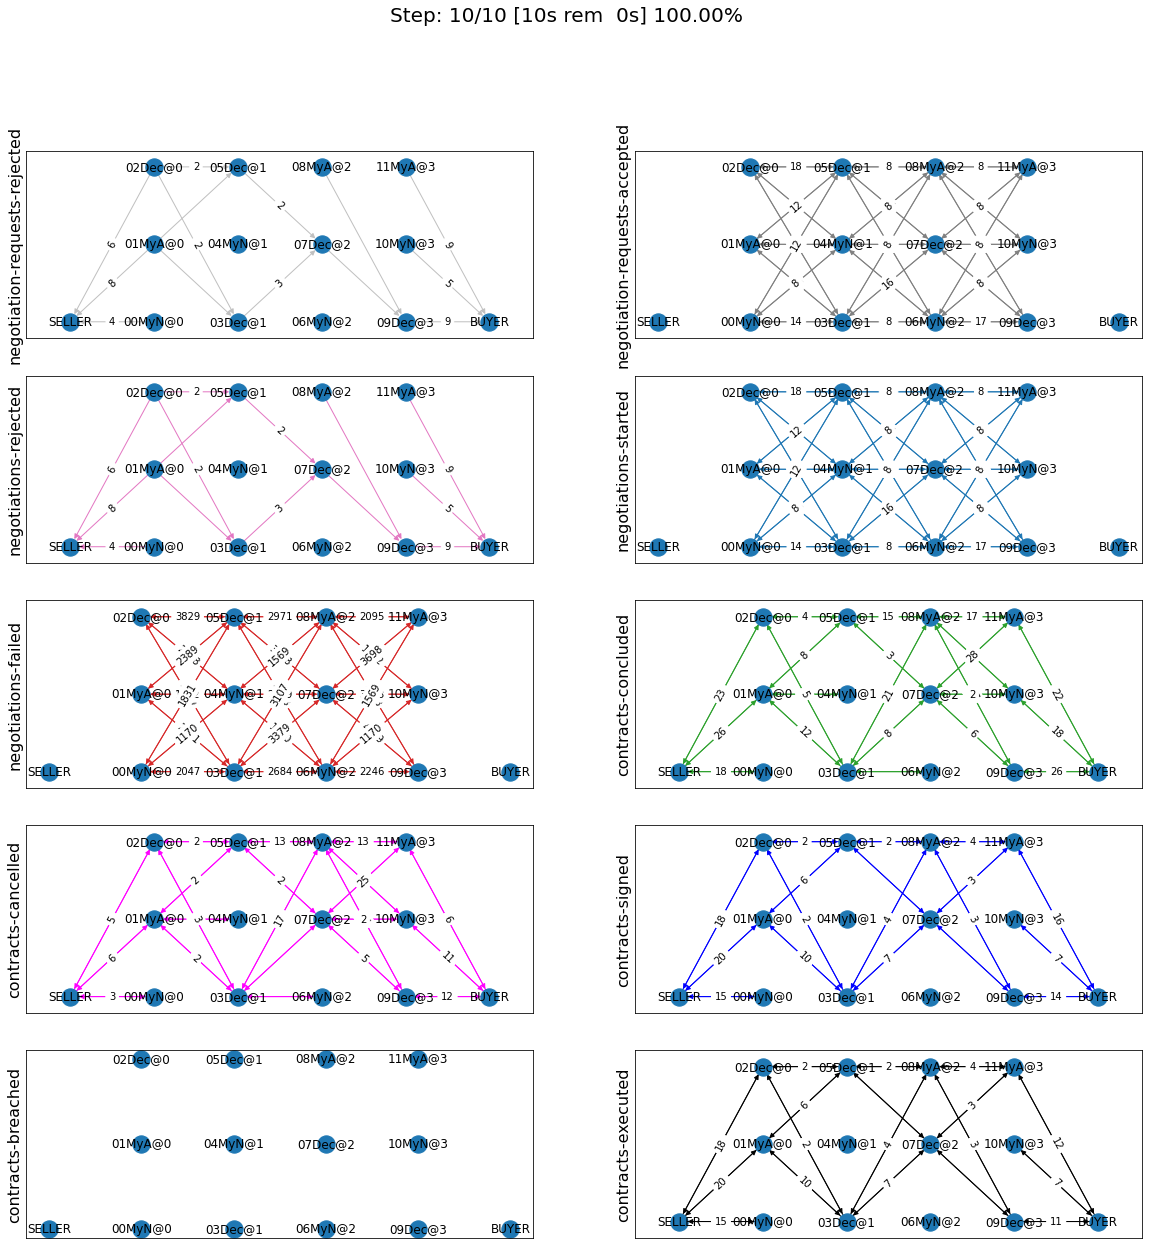

In [24]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyAgent, MyNewAgent], n_steps=10), 
    construct_graphs=True
)
world.run()

world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()



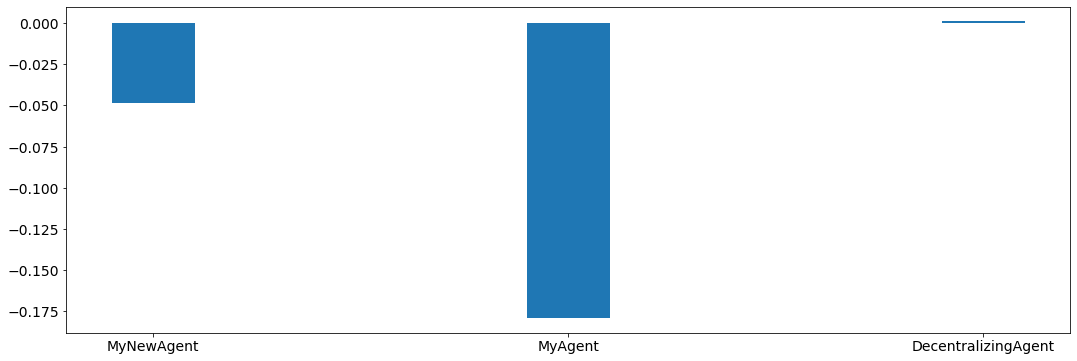

In [25]:
show_agent_scores(world)

OK not bad. It is better than the original agent we developed using only built-in compoenents. If we re-run this notebook, we may get a different result because we do a single world simulation and for a small number of steps. In the acutal competition thousands of simulations will be run so the restuls will be more trustable.  

### Overriding an agent directly

You do not need to know what are the components used by an agent to base your design on it. Let's say that we want to base our design on `DecentralizingAgent` and we will just change the prediction strategy it uses to predict the expected supply and demand. 

This is done using a `FixedTradePredictionStrategy`. We can just create a new *trade prediction strategy* and use it in our agent. This is an example:

In [26]:
from scml.scml2020.components import TradePredictionStrategy
class MyPredictor(TradePredictionStrategy):
    def trade_prediction_init(self):
        inp = self.awi.my_input_product
        self.expected_outputs = self.awi.n_lines * np.ones(self.awi.n_steps, dtype=int)
        self.expected_inputs = self.awi.n_lines * np.ones(self.awi.n_steps, dtype=int)

class MyFinalAgent(MyPredictor, DecentralizingAgent):
    pass

That was much less typing. Notice that the order of `MyPredictor` and `DecentralizingAgent` is very important becuase it is used to calculate the method calling order (MRO) in python. If you reverse them, you will not get any errors but your code will never be called.

Let's test it

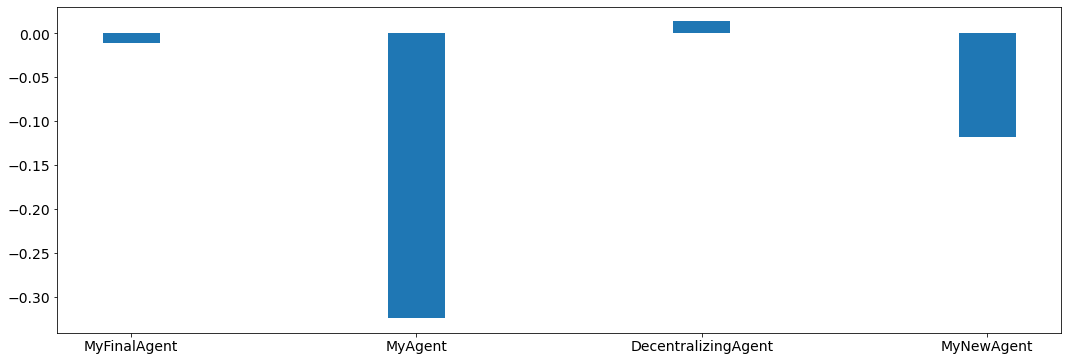

In [27]:
world = SCML2020World(
    **SCML2020World.generate([ComparisonAgent, MyAgent, MyNewAgent, MyFinalAgent]
                             , n_steps=10), 
    construct_graphs=True
)
world.run()
show_agent_scores(world)